## Урок 5. Задача оттока: варианты постановки, возможные способы решения##

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [19]:
import itertools
import warnings

import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

In [10]:
df = pd.read_csv("data/web5/churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


## Распределение классов

In [5]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [11]:
target_feature = 'Exited'
all_features = df.drop(target_feature,axis=1).columns.tolist()

X = df[all_features]
y = df[target_feature]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=0
)

## Классы трансформеров

In [12]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

## Вспомогательные функции

In [13]:
def get_best_model(feats, X, y):

    models = {
        0: {'name': 'LogisticRegression', 'estimator': LogisticRegression()},
        1: {'name': 'RidgeClassifier', 'estimator': RidgeClassifier()},
        2: {'name': 'SGDClassifier', 'estimator': SGDClassifier()},
        3: {'name': 'LinearSVC', 'estimator': LinearSVC()},
        4: {'name': 'DecisionTreeClassifier', 'estimator': DecisionTreeClassifier()},
        5: {'name': 'ExtraTreeClassifier', 'estimator': ExtraTreeClassifier()},
        6: {'name': 'GradientBoostingClassifier', 'estimator': GradientBoostingClassifier()},
    }

    results = dict()
    for k in models.keys():
        classifier = Pipeline([
            ('features',feats),
            ('classifier', models[k]['estimator']),
        ])
        score = cross_validate(
            classifier,
            X,
            y,
            cv=15,
            scoring=('roc_auc', 'f1', 'precision', 'recall'),
        )
        
        key = models[k]['name']
        results[key] = {
            'roc_auc': np.mean(score['test_roc_auc']),
            'f1': np.mean(score['test_f1']),
            'precision': np.mean(score['test_precision']),
            'recall': np.mean(score['test_recall']),
        }
    
    return results

In [44]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Пайплайн

In [14]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

final_transformers = list()

gender = Pipeline([
    ('selector', FeatureSelector(column='Gender')),
    ('ohe', OHEEncoder(key='Gender'))
])

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=cat_col)),
        ('ohe', OHEEncoder(key=cat_col))
    ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),
        ('standard', StandardScaler())
    ])
    final_transformers.append((cont_col, cont_transformer))

feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

## Сравнение моделей

In [17]:

results = get_best_model(feats, X_train, y_train)
pd.DataFrame.from_dict(results, orient='index').sort_values(by='roc_auc', ascending=False)

,roc_auc,f1,precision,recall
GradientBoostingClassifier,0.862777,0.575250,0.771208,0.460098
RidgeClassifier,0.764076,0.212600,0.634133,0.128299
LinearSVC,0.763833,0.244438,0.626275,0.152527
LogisticRegression,0.762073,0.310106,0.596101,0.210749
SGDClassifier,0.734376,0.145932,0.621192,0.088384
DecisionTreeClassifier,0.683945,0.493884,0.481034,0.509222
ExtraTreeClassifier,0.660616,0.460944,0.468895,0.455530


## Подбор гиперпараметров для GradientBoostingClassifier

In [39]:
frozen_params = {
    'random_state': 0,
    'verbose': 0,
}

params = {
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__n_estimators': [100, 300, 500],
    'classifier__subsample': [0.5, 1.0, 1.5],
    'classifier__max_depth': [4, 6, 8, 10],
}

rs = RandomizedSearchCV(
    Pipeline([
        ('features',feats),
        ('classifier', GradientBoostingClassifier(**frozen_params)),
    ]),
    params,
    cv=5,
    scoring='f1',
    refit=False
)
rs.fit(X_train, y_train)
print(rs.best_params_)


{'classifier__subsample': 0.5, 'classifier__n_estimators': 100, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1}


In [40]:
gb_clf = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(
        subsample=0.5,
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        **frozen_params
    )),
])
gb_clf.fit(X_train, y_train)

y_test_pred = gb_clf.predict(X_test)

In [41]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=1.000000, F-Score=0.617, Precision=0.723, Recall=0.538


Confusion matrix, without normalization
[[1991    0]
 [ 509    0]]


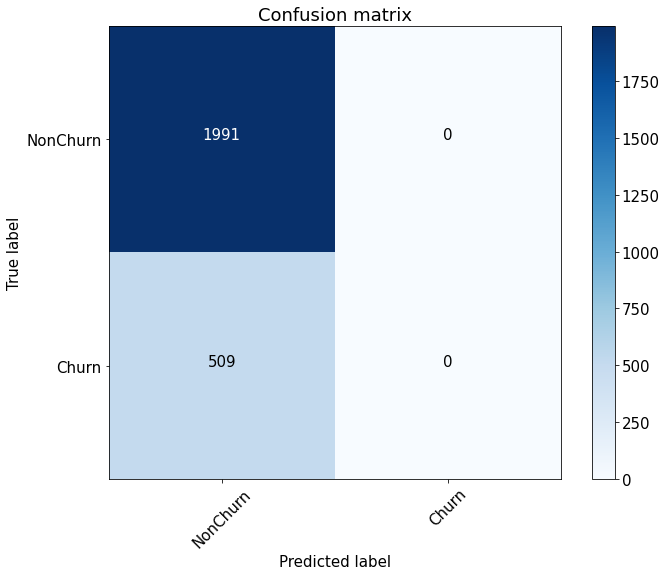

In [45]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_test_pred>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(
    cnf_matrix,
    classes=['NonChurn', 'Churn'],
    title='Confusion matrix',
)
plt.savefig("conf_matrix.png")
plt.show()

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

### Здесь похоже опечатка - предсказываем Exited (тех кто "ушел"), соответственно 2 доллара получим с тех кому правильно предсказали Exited=0, то есть с TN ... ?

In [53]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

effect = (TN * 2) - (TN + FN)
print(effect)

1482
